# Homework 5

Spencer Pease  
ASTR 427

----------------------------

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import random as rand

import pycuda.autoinit
import pycuda.driver as drv

from pycuda.compiler import SourceModule
from pycuda import curandom

%matplotlib inline

In [2]:
# create consistent number of evaluations to perform for all monte carlo integrations
points = 1000000

## Problem 1

In [3]:
# estimate pi with cpu

def monteCarlo(n):
    """
    monteCarlo defines a function that integrates a unit circle (radius = 1) using Monte Carlo integration
    with and integer n number of evaluations.
    - n: integer number of evaluations to be used in the Monte Carlo integration
    - return: the area of the unit circle (~pi)
    """
    
    # number of guesses that fall on or within the circle
    inside = 0
    
    for _ in range(n):
        x = rand.random()
        y = rand.random()
        
        if x**2 + y**2 <= 1:
            inside += 1
    
    # area for one quadrant of the circle
    area = float(inside)/n
    
    # area of the entire circle (~pi)
    return area*4

In [4]:
%%time

print "pi:", monteCarlo(points)

pi: 3.143392
Wall time: 605 ms


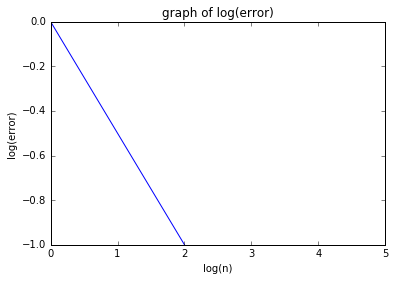

Monte Carlo gets more accurate with more evaulation points


In [5]:
# plotting error

n = np.arange(1, 10001)
error = 1/np.sqrt(n) # error for Monte Carlo is proportional to 1/sqrt(n)

plt.figure(1)
plt.xlim(0, 5)
plt.ylim(-1, 0)
plt.plot(np.log(n), np.log(error))

# labeling
plt.title('graph of log(error)')
plt.xlabel('log(n)')
plt.ylabel('log(error)')

plt.show()

print "Monte Carlo gets more accurate with more evaulation points"

## Problem 2

In [6]:
# estimate pi with gpu
def monteCarlo_gpu(n):
    """
    monteCarlo_gpu performs Monte Carlo integration on a unit circle with an integer n evaluatios.
    This function makes use of CUDA to run more efficiently.
    - n: integer number of evualuations to use for Monte Carlo
    - return: the area of the unit circle (~pi)
    """
    
    # create function that runs on the gpu (meta-programming)
    mod = SourceModule("""
    __global__ void mc_gpu(float *dest, float *x, float *y, int n)
    {
        const int i = blockIdx.x * blockDim.x + threadIdx.x;

        if (i <= n) return;
        if ( (pow(x[i],2) + pow(y[i],2)) < 1 ) 
        {
            dest[i] = 1;
        }
        else 
        {
            dest[i] = 0;
        }
    }
    """)
    
    # assign meta-function to usable python function
    mc_gpu = mod.get_function("mc_gpu")

    # generate all random x and y guesses
    x = np.random.uniform(0, 1, n).astype(np.float32)
    y = np.random.uniform(0, 1, n).astype(np.float32)
    
    # create array to store results retrieved from gpu
    out_loc = np.zeros_like(x) 
    
    # fill created array with results from gpu
    mc_gpu(drv.Out(out_loc), drv.In(x), drv.In(y), block=(512, 1, 1), grid=(int(np.ceil(n/512.0)), 1))
    
    # area of one quadrant of unit circle
    area = np.sum(out_loc)/n
    
    return 4*area # area of circle (~pi)

In [7]:
%%time

print monteCarlo_gpu(points)

3.140588
Wall time: 97 ms
